# GPU programming with PyOpenCL

Layout:

1. Comparison of modern CPU and GPU
2. Introduction to OpenCL 
3. Comparison with other ways of programming GPU
4. My very first kernel: Element-wise addition
5. Parallel programming design patterns
6. Metaprogramming in PyOpenCL
7. Conclusions

## Comparison of modern CPU and GPU

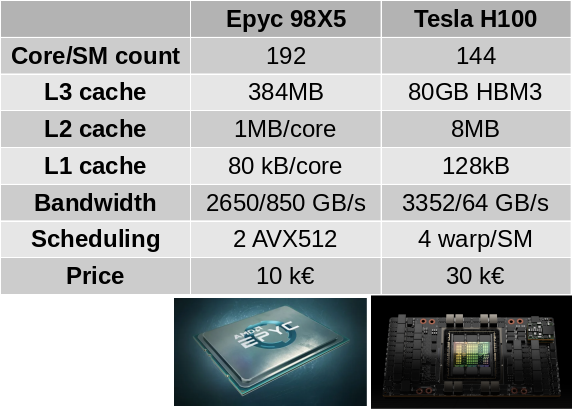


### They are not that different: both are many-core processors.

* CPUs are still faster (MHz) and have lower latency to memory
* GPUs are have more compute power and larger bandwidth to memory

## Introduction to OpenCL
* Vendor & platform neutral parallel programming language to address CPU, GPU, FPGA and other types of accelerators. 
* Initated by Apple in 2008 and managed by the Khronos group, currently at version 3.0. 

* There is a strict separation between host code and device code (called kernels).
* Kernels are written in a subset of C99 (without pointers, nor recursion) and compiled at _runtime_.

* Bindings for host code, initially in C are available for all programming languages.

* Sycl (Intel) is the descendent of OpenCL where C++ host code can be mixed with kernels (à la CUDA).

* There is a direct mapping between CUDA kernels and OpenCL (version 1.2).

## Definition:

In parallel programming, a `kernel` is the core part of the computational code, without the outer loop. It runs in parallel on all cores of the device.

In [1]:
import numpy as np

size = 1000
a = np.random.random(size)
b = np.random.random(size)
res = np.empty_like(a)

for idx in range(size):
    res[idx] = a[idx] + b[idx]

# ⚠ This is not vectorized numpy code ⚠

The kernel is `res[i] = a[i] + b[i]`.

The size of the problem, `size`, is precised at runtime, usually in the host code.

The position of the working element `idx` is obtained via specific API calls.

## GPU programming languages ...
<div>
    <img src="languages.svg" width="1000">
</div>

## PyOpenCL

* Expose the full OpenCL API
* Explicit kernels in C99 
* Explicit memory management
* Explicit device and context management
* Asynchronous execution with queues and events
* Runtime compilation (since the driver contains the compiler)
* Many metaprogramming features to expose advanced parallel algorithms
* Integration in Jupyter notebooks

In [2]:
#Integration with Jupyter notebooks:
%load_ext pyopencl.ipython_ext

import pyopencl as cl
import pyopencl.array as cla

In [3]:
#Creation of the OpenCL context which holds the memory on the device
ctx = cl.create_some_context(interactive=True)

# The command queue is used to interact with the device asynchronously
queue = cl.CommandQueue(ctx, 
                         properties=cl.command_queue_properties.PROFILING_ENABLE)

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x55f3c21393b0>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x55f3c1fead68>


Choice [0]: 0


Choose device(s):
[0] <pyopencl.Device 'NVIDIA RTX A5000' on 'NVIDIA CUDA' at 0x55f3c2139420>
[1] <pyopencl.Device 'Quadro P2200' on 'NVIDIA CUDA' at 0x55f3c21394b0>


Choice, comma-separated [0]: 0


Set the environment variable PYOPENCL_CTX='0:0' to avoid being asked again.


### Preparation of some test data:

* GPUs need to work on large chunks of data to be efficient, here we work on 64 MB of data
* Allocation of the memory on the device and transfer of the data
* Convention: the `_d` suffix indicates the object lives on the device

In [4]:
# Array creation
shape = (2**24,)
print(f"size of the probem {shape}")
a = np.random.random(shape).astype(np.float32)
b = np.random.random(shape).astype(np.float32)
print(f"Allocated memory for one buffer: {a.nbytes}")

#Reference result, calculated in float32
ref = a+b 

# Send data to the devicem using the `queue`
a_d = cla.to_device(queue, a)
b_d = cla.to_device(queue, b)
#prepare output buffer
res_d = cla.empty_like(a_d)

print(type(res_d), res_d)

size of the probem (16777216,)
Allocated memory for one buffer: 67108864
<class 'pyopencl.array.Array'> [0. 0. 0. ... 0. 0. 0.]


### Structure of an OpenCL `kernel`:

* Kernels are `void` functions: they do not return anything.
* Kernels are declared with the `kernel` keyword
* Arrays are declared `global` which indicates the memory of the device
* The position of the worker is obtained with `get_global_id()` function

In [5]:
%%cl_kernel
// OpenCL kernel written in Jupyter:

kernel void add(global float* a,
                global float* b,
                global float* res){
    int idx = get_global_id(0);
    res[idx] = a[idx] + b[idx];
}

### Integration with Jupyter:

* The `%%cl_kernel` on the first line indicates the cell contains OpenCL code
* Comments need to be indicated like in C
* The code is compiled when the cell is executed
* Kernels are exposed in the Python namespace automatically!

In [6]:
%%cl_kernel
// Parallel programming hello-world

kernel void add(global float* a,
                global float* b,
                global float* res){
    int idx = get_global_id(0);
    res[idx] = a[idx] + b[idx];
}

In [7]:
# Execution of a kernel:

evt = add(queue, shape, None,             # Indicate the queue, the size of the problem and the chunking (None=auto)
          a_d.data, b_d.data, res_d.data) # This needs to match the signature of the kernel
print(evt)                                # Since execution is asynchronous, the event is the handle to the processing 

In [8]:
print("The results are correct: ",
np.allclose(ref, res_d.get()))

The results are correct:  True


In [9]:
print(f"Execution time on GPU: {1e-6*(evt.profile.end-evt.profile.start):.3f} ms\nExecution time on CPU:")
%timeit a+b

Execution time on GPU: 0.346 ms
Execution time on CPU:
9.29 ms ± 6.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Parallel programming design patterns

* Map: Element-wise operations like the `add` kernel.
* Gather: Stencil like operation, for example convolutions.
* Scatter: write at variable position, requires atomic operations.
* Reduction: perform the sum for all elements in an array.
* Scan: Perform the `cumsum`, sum of all previous elements, used in compactions.
* Sort: Bitonic sort is one example of parallel sort.
* ...

Beside `Map`, all kernel require dozens to hundreeds of lines of code to implement the algorithm!

PyOpenCL provides templates to all those algorithms making programmer's life simpler.

### Generating `Map` kernels

In [10]:
from pyopencl.elementwise import ElementwiseKernel

t_add = ElementwiseKernel(ctx, 
                          arguments="float* a, float* b, float* res", 
                          operation="res[i] = a[i] + b[i]")

res_d.fill(0.0)                  # Reset the destination array
t_add(a_d, b_d, res_d)           # Launch the kernel

print("Results are correct:",
np.allclose(ref, res_d.get()))

Results are correct: True


In [11]:
# Even more trivial:
c_d = a_d + b_d

%time a_d + b_d

type(c_d)

CPU times: user 109 µs, sys: 46 µs, total: 155 µs
Wall time: 159 µs


pyopencl.array.Array

### Reduction kernel, like the sum of all elements in an array:
![Reduction kernel](kernel-code-sum-reduction.png)

One can use `reductions` to perform the scalar product ... 
`a.b = sum(a[i]*b[i])` where `a[i]*b[i]` is the **map** operation and the sum is the **reduction**.

Reduction are not limited to addition, any associative operation is usable like `*`, `min`, `max`, ... 

**⚠** addition is not strictly associative for floating point numbers, but that's another story.

In [12]:
# Dot product implemented as reduction kernel
from pyopencl.reduction import ReductionKernel
dot = ReductionKernel(ctx, 
                      dtype_out=np.float32, 
                      neutral="0",
                      reduce_expr="a + b", 
                      map_expr="a[i] * b[i]",
                      arguments="__global float* a, __global float* b")

print("Validation of the result in 32-bits:",
np.isclose(dot(a_d, b_d).get(), np.dot(a,b)))

# 32bits precision is not enough ! 
a64 = a.astype(np.float64)
b64 = b.astype(np.float64)
print("Validation of the result in 64-bits:",
np.isclose(dot(a_d, b_d).get(), np.dot(a64,b64)))

Validation of the result in 32-bits: False
Validation of the result in 64-bits: True


In [13]:
print("Performance evaluation on the GPU:")
%timeit dot(a_d, b_d).get()

print("Performance evaluation on CPU (32 bits):")
%timeit np.dot(a,b)
print("Performance evaluation on CPU (64 bits):")
%timeit np.dot(a64,b64)

Performance evaluation on the GPU:
424 µs ± 365 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Performance evaluation on CPU (32 bits):
4.39 ms ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Performance evaluation on CPU (64 bits):
1.91 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Visualisation of the code generated by PyOpenCL

Reduction can have multiple stages, here is it implemented with 2 kernels working with workgroups of 256 threads...

* Stage 2 is reducing 256 values coming from stage 1
* Stage 1 is reducing 256² values, i.e. 64k threads are used *simulateneously*
* Stage 0 is a simple loop over elements, each thread is reading 1k elements in a `for` loop

In [14]:
print(dot.stage_2_inf.source) 

//CL//
    #define PCL_GROUP_SIZE 256
    #define PCL_READ_AND_MAP(i) (pyopencl_reduction_inp[i])
    #define PCL_REDUCE(a, b) (a + b)

        #if __OPENCL_C_VERSION__ < 120
        #pragma OPENCL EXTENSION cl_khr_fp64: enable
        #endif
        #define PYOPENCL_DEFINE_CDOUBLE

    #include <pyopencl-complex.h>

    

    typedef float pcl_out_type;

    __kernel void reduce_kernel_stage2(
      __global pcl_out_type *pcl_out__base, long pcl_out__offset,
      __global float *pyopencl_reduction_inp, __global float *a__base, long a__offset, __global float *b__base, long b__offset, 
      long pcl_start, long pcl_step, long pcl_stop,
      unsigned int pcl_seq_count, long n)
    {
        __global pcl_out_type *pcl_out = (__global pcl_out_type *) (
            (__global char *) pcl_out__base + pcl_out__offset);
        __global float *a = (__global float *) ((__global char *) a__base + a__offset);
__global float *b = (__global float *) ((__global char *) b__base + b__offset);

     

In [15]:
print(dot.stage_1_inf.source)

//CL//
    #define PCL_GROUP_SIZE 256
    #define PCL_READ_AND_MAP(i) (a[i] * b[i])
    #define PCL_REDUCE(a, b) (a + b)

        #if __OPENCL_C_VERSION__ < 120
        #pragma OPENCL EXTENSION cl_khr_fp64: enable
        #endif
        #define PYOPENCL_DEFINE_CDOUBLE

    #include <pyopencl-complex.h>

    

    typedef float pcl_out_type;

    __kernel void reduce_kernel_stage1(
      __global pcl_out_type *pcl_out__base, long pcl_out__offset,
      __global float *a__base, long a__offset, __global float *b__base, long b__offset, 
      long pcl_start, long pcl_step, long pcl_stop,
      unsigned int pcl_seq_count, long n)
    {
        __global pcl_out_type *pcl_out = (__global pcl_out_type *) (
            (__global char *) pcl_out__base + pcl_out__offset);
        __global float *a = (__global float *) ((__global char *) a__base + a__offset);
__global float *b = (__global float *) ((__global char *) b__base + b__offset);

        __local pcl_out_type pcl_ldata[PCL_GROUP_SIZE];

  

In [16]:
source = dot.stage_1_inf.source + "\n" + dot.stage_2_inf.source
nblines  = len(source.split('\n'))
print(f"Length of the source code: {nblines} lines")

Length of the source code: 314 lines


### Scan kernel, sum of all previous elements from the array:
![Scan kernel](300px-Prefix_sum_16.svg.png)
Their typical application is *in memory* compaction or in compression algorithms. 

Once again, this is not limited to the `+` operation, it is valid for any associative operation.

In `numpy` this is implemented in the `cumsum` function:

In [17]:
from pyopencl.scan import GenericScanKernel
cumsum = GenericScanKernel(ctx, 
                           np.float32,
                           arguments="__global float* ary, __global float* out",
                           input_expr="ary[i]",
                           scan_expr="a+b", 
                           neutral="0",
                           output_statement="out[i] = item;")
cumsum(a_d, res_d)
print("Results are corrects:", np.allclose(res_d.get(),np.cumsum(a64)))

Results are corrects: True


In [18]:
print("Performances of `cumsum` implemented in pyopencl:")
%timeit cumsum(a_d, res_d).wait()
print("Performances of `cumsum` implemented in numpy (32 bits):")
%timeit np.cumsum(a)
print("Performances of `cumsum` implemented in numpy (64 bits):")
%timeit np.cumsum(a64)

Performances of `cumsum` implemented in pyopencl:
2.21 ms ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Performances of `cumsum` implemented in numpy (32 bits):
49.3 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Performances of `cumsum` implemented in numpy (64 bits):
54.6 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


`Scan` kernels are at the core of **memory compaction** but also of **compression** algorithm, as demonstrated in:
https://doi.org/10.1107/S1600577518000607

## Conclusion

* PyOpenCL is an interesting Python binding for doing GPU programming:
  - Platform independant (i.e. no vendor lock-in).
  - Comfort of Python and Jupyter.
  - Full control of execution and memory management.
  - Scales to larger projects (https://github.com/silx-kit).
  - Can also exploit many-core CPUs (without GIL issues).
  - Great for continuous integration of GPU code using CPU drivers.
  - Fully open source driver exists (like PortableCL).
* Parallel programming design patterns are well documented.
  - Knowing them allows to address performance issues with the proper tool.
  - Most of them are already implemented into PyOpenCL/PyCuda via metaprogramming.
* Kudos to Andreas Kloeckner, author of PyOpenCL.